In [1]:
import phase_STEM as ps

C:\ProgramData\Miniconda3\envs\stem_images\Lib\site-packages\paramiko\pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\ProgramData\Miniconda3\envs\stem_images\Lib\site-packages\paramiko\transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
ps._version.__version__

'0.0.5'

In [31]:
import numpy as np

In [3]:
#from scipy.optimize import curve_fit

### Loading raw DPC dataset (.emd file) to reconstruct OBF image and iDPC image

In [38]:
path_file = "/..../"

In [57]:
dpc1, (resolution, unit), mode = ps.io.loading_data(path_file+'simu/img_iDPC_1.mrc')
dpc2, (resolution, unit), mode = ps.io.loading_data(path_file+'simu/img_iDPC_2.mrc')
dpc3, (resolution, unit), mode = ps.io.loading_data(path_file+'simu/img_iDPC_3.mrc')
dpc4, (resolution, unit), mode = ps.io.loading_data(path_file+'simu/img_iDPC_4.mrc')

In [59]:
resolution = 0.0369357

In [60]:
unit

'nm'

In [101]:
%matplotlib inline

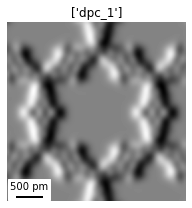

In [102]:
ps.tools.plot_image(dpc1['image'], properties= {
             'resolution': resolution,
              'unit': unit,
              'bar location':'',
             'image titles': 'dpc_1',
             'figsize':3,
              'cmap':'grey',
              'dpi': 600,
              'image format':'.jpeg',
              'showing titles': True,
             'cropping image': [True, [49,49], [90,90]],
             'saving image': False,
             'saving path':path_file+ "/ADF_image(2nm)"
              })

In [90]:
#convert the images into ndarray
# OBF requires the shape of image with a squared size
DPCs = [dpc1['image'], dpc2['image'], dpc3['image'], dpc4['image']]
cropped_DPCs = []
for item in DPCs:
    cropped_DPCs.append(ps.tools.crop_matrix(item, (0,1), (49,49), (90,90)))

In [62]:
titles = ['DF4-A', 'DF4-B', 'DF4-C', 'DF4-D']

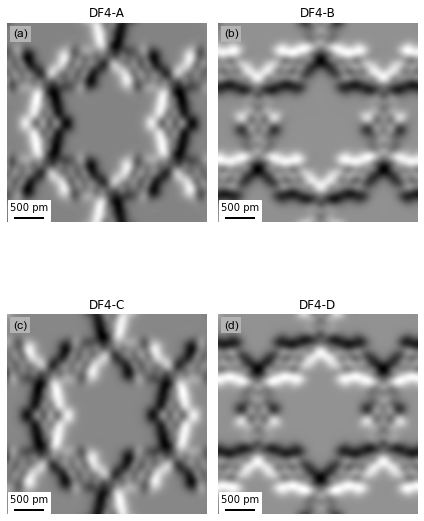

In [103]:
ps.tools.plot_image(cropped_DPCs, properties= {
             'resolution': resolution,
              'unit': unit,
              'bar location':'',
             'image titles': titles,
             'figsize':3,
              'cmap':'grey',
              'dpi': 600,
              'image format':'.jpeg',
              'showing titles': True,
             'cropping image': [False, [128,128], [256,256]],
             'saving image': False,
             'saving path':path_file+ "/ADF_image(2nm)"
              })

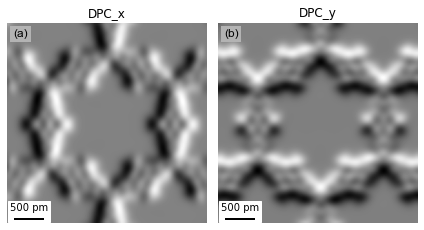

In [104]:
CoMx =  cropped_DPCs[2] - cropped_DPCs[0]
CoMy = cropped_DPCs[1] - cropped_DPCs[3]

CoM = [CoMx, CoMy]
ps.tools.plot_image(CoM, properties= {
             'resolution': resolution,
              'unit': unit,
              'bar location':'',
             'image titles': ['DPC_x', 'DPC_y'],
             'figsize':3,
              'cmap':'grey',
              'dpi': 600,
              'image format':'.jpeg',
              'showing titles': True,
             'cropping image': [False, [128,128], [256,256]],
             'saving image': True,
             'saving path':path_file+ "/cropped_DPC_xy"
              })

In [70]:
idpc1 = ps.analysis.iDPC_DCTBuilder(CoMx, CoMy, pixel_size_R = 1, epsilon = 1e-3)

In [66]:
theta, flip = idpc1.optimize_rotation(CoM[0], CoM[1], thetas = np.arange(-90, 91, 1), pixel_size_R = 1, epsilon = 3e-2)

Calculating:   0%|          | 0/362 [00:00<?, ?iteration/s]

Does it need to flip: False
The rotation angle is: -90.00 degrees


In [71]:
idpc_image1 = idpc1.run(theta, flip)

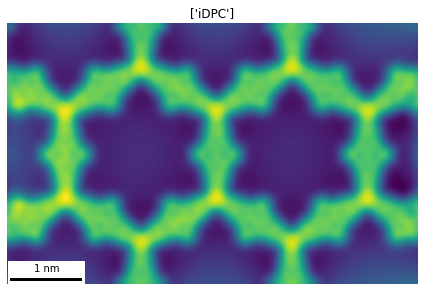

In [72]:
ps.tools.plot_image(-idpc_image1, properties= {
             'resolution': resolution,
              'unit': 'nm',
              'bar location':'',
             'image titles': "iDPC",
             'figsize':6,
              'cmap':'viridis',
              'dpi': 600,
              'image format':'.jpeg',
              'showing titles': True,
             'cropping image': [False, [128,128], [256,256]],
             'saving image': True,
             'saving path':path_file+ "/iDPC_1"
              })

In [122]:
cal_idpc = ps.analysis.Noniterate_iDPCBuilder(CoMx, CoMy, epsilon = 3e-3)

In [124]:
# For our Themis Z machine, the rotation angle is about 88 (or 44) degrees, and it needs to flip (flip the directions of x- and y-axis)
# If you use A-C for CoMx and B-D for CoMy, then the angle is 88 degrees.

theta_1, flip_1 = cal_idpc.optimize_rotation(CoMx, CoMy, thetas = np.arange(-90, 90, 1), epsilon = 1e-3)

Calculating:   0%|          | 0/360 [00:00<?, ?iteration/s]

It is needed to preserve the intensity
Does it need to flip: False
The rotation angle is: -90.00 degrees


In [125]:
idpc = cal_idpc.run(theta_1, flip_1, expanding=True)

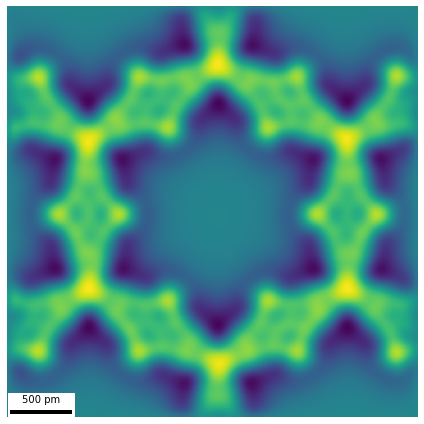

In [126]:
ps.tools.plot_image(idpc, properties= {
             'resolution': resolution,
              'unit': 'nm',
              'bar location':'', # the location of scale-bar in image
             'image titles': 'iDPC',
             'figsize':6,
              'cmap':'viridis',
              'dpi': 600, # the dpi for saving image 
              'image format':'.jpeg',
              'showing titles': False,
             'cropping image': [False, [1765,848], [128,128]], # you can amplify the small interested region of image
             'saving image': True,   # if you want to save it, then 'True'
             'saving path':path_file+ "iDPC"  # choose the saving folder address and the name of this figure
              })

In [73]:
# Firstly, we need the aberrations measured by probe Cs-corrector
#Adopting the notations supplied by Uhlemann and Haider

ab = {        'C1': -2,                                   #defocus (over focus positive), a real value
              'A1': 1.8+ 1j*np.radians(-56.31),     #Two-fold astigamastism
              'B2': 6.4 + 1j*np.radians(-51.34),    #Axial coma, a complex, here using the result measured by Sherpa
              'A2': 69 + 1j*np.radians(60.46),         #Three-fold astigmatism
              'C3': 800,                                #Spherical aberration
              'A3': 781 + 1j*np.radians(-50.19),          #Four-fold astigmatism
              'S3': 391 + 1j*np.radians(-32.47),          #Axial star aberration
              'A4': 1140 + 1j*np.radians(-52.13)}

In [16]:
# Firstly, we need the aberrations measured by probe Cs-corrector
#Adopting the notations supplied by Uhlemann and Haider

ab = {        'C1': 0,                                   #defocus (over focus positive), a real value
              'A1': 0 + 1j*np.radians(0),     #Two-fold astigamastism
              'B2': 0 + 1j*np.radians(0),    #Axial coma, a complex, here using the result measured by Sherpa
              'A2': 40 + 1j*np.radians(0),         #Three-fold astigmatism
              'C3': 100,                                #Spherical aberration
              'A3': 0 + 1j*np.radians(0),          #Four-fold astigmatism
              'S3': 0 + 1j*np.radians(0),          #Axial star aberration
              'A4': 0 + 1j*np.radians(0)}

ab = {        'C1': 0,
              'A1': 0.26 + 1j*np.arctan(1.52/0.26),
              'B2': -42.5 + 1j*np.arctan(1.2/42.5),
              'A2': -12.2 + 1j*np.arctan(8.3/12.2),
              'C3': -1492,
              'A3': 969.7 + 1j*np.radians(165.2),
              'S3': 818.7 + 1j*np.radians(-101.2),
              'A4': 7469 + 1j*np.radians(40.1)}

In [13]:
pr, pk = ps.analysis.construct_probe(128, 0.02, ab, wavelength)

In [74]:
wavelength = 0.00196 # in nm

In [ ]:
ps.tools.plot_vector_image(pr, title=['probe'], imgsize = 6, storing = [False, 'path_save'])

In [14]:
ps.analysis.interaction_constant(300)

1.8534233889477069e-06

In [75]:
#describing the geometric planes of DF4 detectors

segments = np.array(([-45,45], [45,135], [135,225], [225,315]), dtype = np.float64)

In [97]:

parameters = {"sample thickness(nm)": 10,
             "wavelength(nm)": wavelength,
             "pixel size(nm)": resolution,
              "dose rate(e-Å-2)": 1,
             "collection angles(rad)": [0.0, 0.034], 
             "semi_convergence angle(rad)": 0.015,
             "pixelnumber of filters": cropped_DPCs[0].shape, #controlling the pixel size of the filter
             "virtual grids in one segment detector": 20}

In [98]:
#built_WPO = ps.analysis.phase_filters_GPU(ab, segments, parameters, slices=[False, 20], single_side_band=False, process=True)

built_WPO, num = ps.analysis.phase_filters_GPU(ab, segments, parameters, slices=1, process=True)

Building:   0%|           [ time left: ? ]

--- 2 seconds left!
The whole process takes 7 seconds.


In [105]:
wpo = []
for i in built_WPO:
    wpo.append(i/num)

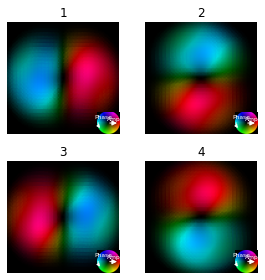

In [106]:
ps.tools.plot_vector_image(wpo, title=['1', '2', '3', '4'], imgsize = 4, storing = [False, 'path_save'])

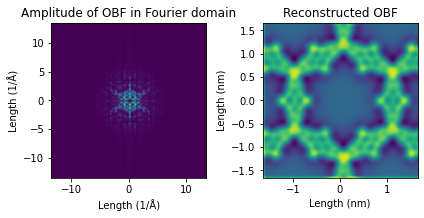

In [108]:
Builder= ps.analysis.OBFBuilder(cropped_DPCs, wpo, parameters)
OBF_img, OBF_Q= Builder.reconstruct_OBF()

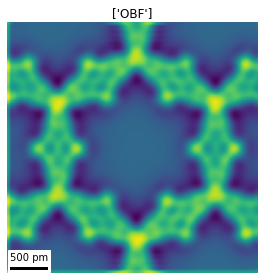

In [110]:
#suggesting ranning this command in "%matplotlib qt5", then choosing "hanning or hamming"
ps.tools.plot_image(OBF_img, properties= {
             'resolution': resolution,
              'unit': 'nm',
              'bar location':'',
             'image titles': 'OBF',
             'figsize':4,
              'cmap':'viridis',
              'dpi': 600,
              'image format':'.jpeg',
              'showing titles': True,
             'cropping image': [False, [1040,1040], [200,200]],
             'saving image': True,
             'saving path':path_file+ "/OBF_15mrad"
              })

In [111]:
FM_STEM = ps.analysis.FMSTEMBuilder(CoMx, CoMy, stepsize=0.01, n_iter=30, regHighpass=1e-4)

Calculating:   0%|          | 0/362 [00:00<?, ?iteration/s]

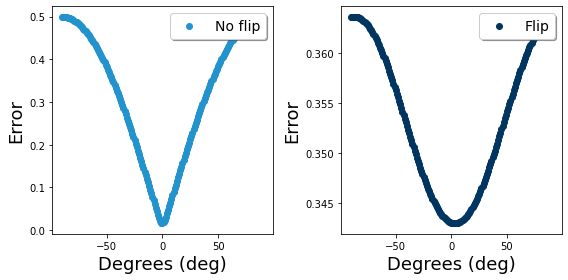

Does it need to flip: False
The rotation angle is: -90.00 degrees


In [112]:
tha, flp = FM_STEM.optimize_rotation(CoMx, CoMy, np.arange(-90,91,1), 
                            n_iter = 3, stepsize = 1, regHighpass = 1e-4)

In [114]:
fm, fm_errors = FM_STEM.run(tha, flp, epsilon=1e-16)

Iteration: 3: break
You can change the iterations through <epsilon>


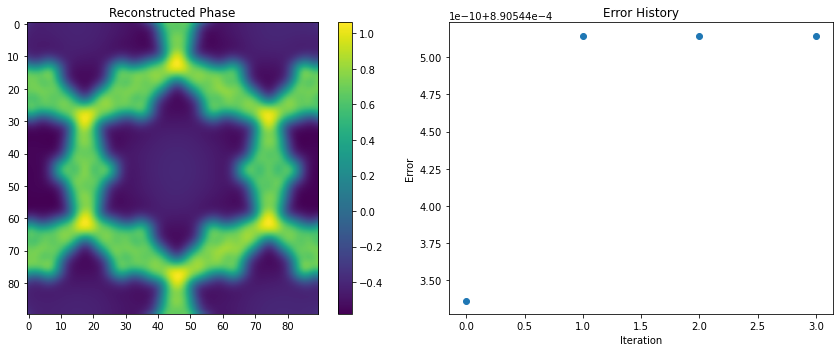

In [115]:
FM_STEM.display()

In [116]:
fm = ps.analysis.Noniterate_FMBuilder(CoMx, CoMy, epsilon=1e-3, mask=None)

In [118]:
#idpc_dft = dft_idpc.run(theta, flip, expanding=True)
t1, f1 = fm.optimize_rotation(CoMx, CoMy, thetas = np.arange(-90, 90, 1), epsilon = 1e-3)

Calculating:   0%|          | 0/360 [00:00<?, ?iteration/s]

It is needed to preserve the intensity
Does it need to flip: False
The rotation angle is: 0.00 degrees


In [119]:
fmstem = fm.run(t1, f1, expanding=True)

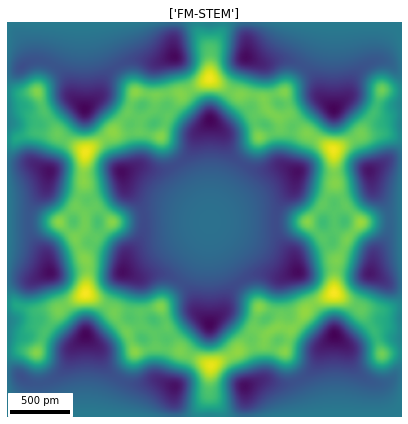

In [121]:
ps.tools.plot_image(-fmstem, properties= {
             'resolution': resolution,
              'unit': unit,
              'bar location':'',
             'image titles': 'FM-STEM',
             'figsize':6,
              'cmap':'viridis',
              'dpi': 600,
              'image format':'.jpeg',
              'showing titles': True,
             'cropping image': [False, [1024,1024], [256,256]],
             'saving image': True,   # if you want to save it, then 'True'
             'saving path':path_file+ "fmstem"  # choose the saving folder address and the name of this figure
              })

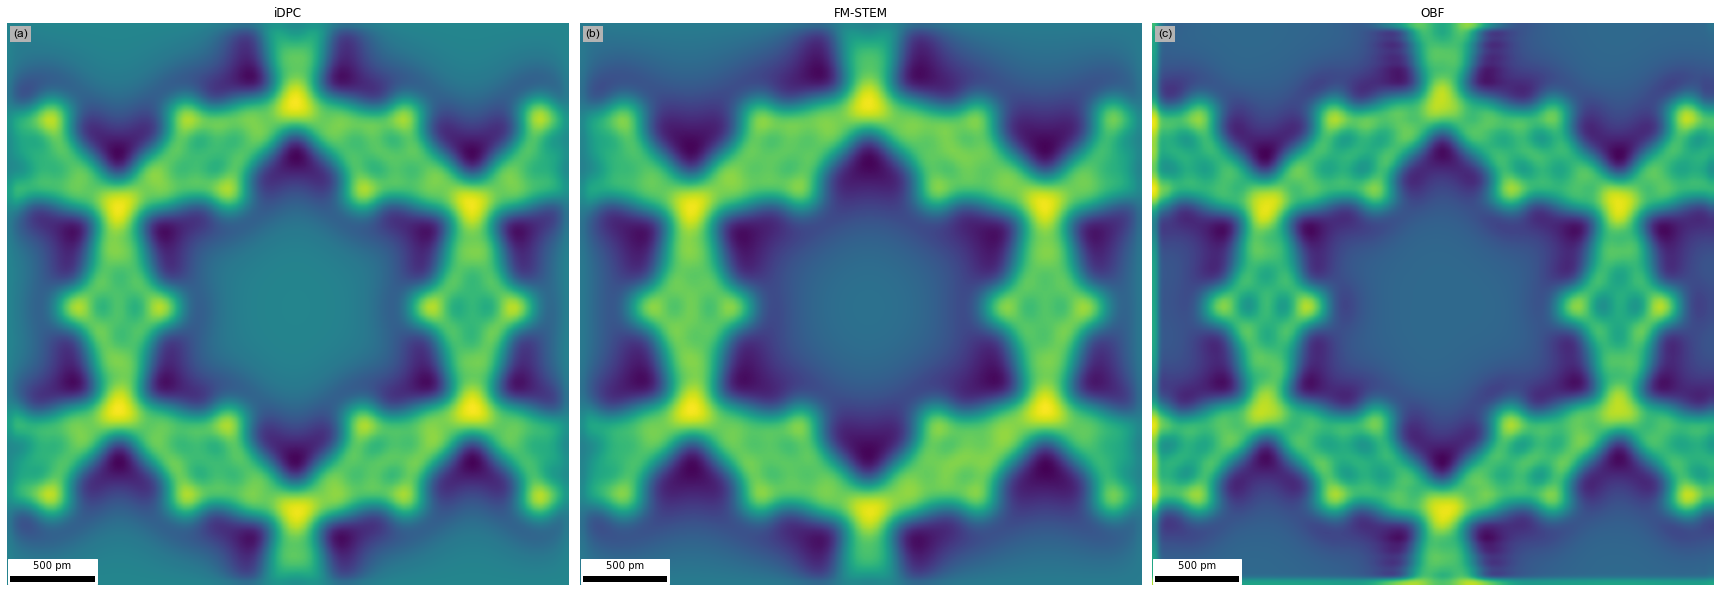

In [128]:
%matplotlib inline
display = [idpc, -fmstem, OBF_img]
titles_compare = ['iDPC','FM-STEM', 'OBF']
ps.tools.plot_image(display, properties= {
             'resolution': resolution,
              'unit': 'nm',
              'bar location':'',
             'image titles': titles_compare,
             'figsize':8,
              'cmap':'viridis',
              'dpi': 600,
              'image format':'.jpeg',
              'showing titles': True,
             'cropping image': [False, [1040,1040], [200,200]],
             'saving image': True,
             'saving path':path_file+ "simu_images"
              })

In [ ]:
%matplotlib qt5
profile = ps.tools.line_intensity_profile(display, titles_compare, resolution, width=5, length_unit='nm', zoom_in = False)

### Saving results

In [ ]:

data = h5py.File(f"{path_file}/simu_images", 'w')
reconstruct = data.create_group(str(resolution))
for i, n in enumerate(display):
    reconstruct.create_dataset(titles_compare[i], data= n)
data.close()